In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import logging
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("Optimized libraries imported successfully!")

# Define SMAPE function
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    denominator = (np.abs(actual) + np.abs(predicted))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    
    smape_value = (100 / len(actual)) * np.sum(2 * np.abs(predicted - actual) / denominator)
    return smape_value

# FAST feature extraction - minimal but effective
def extract_features_fast(catalog_text):
    """Ultra-fast feature extraction with only essential features"""
    features = {
        'weight': 0.0,
        'volume': 0.0, 
        'count': 0.0,
        'catalog_length': 0,
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
    }
    
    if pd.isna(catalog_text):
        return features
    
    text = str(catalog_text).lower()
    
    # Quick text length
    features['catalog_length'] = len(text)
    
    # Fast weight extraction
    weight_match = re.search(r'(\d+\.?\d*)\s*oz', text)
    if weight_match:
        try:
            features['weight'] = float(weight_match.group(1))
        except:
            pass
    
    # Fast volume extraction  
    volume_match = re.search(r'(\d+\.?\d*)\s*fl\s*oz', text)
    if volume_match:
        try:
            features['volume'] = float(volume_match.group(1))
        except:
            pass
    
    # Fast count extraction
    count_match = re.search(r'(\d+)\s*(count|pack|ct|tea bags)', text)
    if count_match:
        try:
            features['count'] = float(count_match.group(1))
        except:
            pass
    
    # Quick boolean flags
    features['is_organic'] = 1 if 'organic' in text else 0
    features['is_gluten_free'] = 1 if 'gluten free' in text else 0  
    features['is_vegan'] = 1 if 'vegan' in text else 0
    
    return features

def create_features_fast(df, has_price=False):
    """Fast feature creation without complex processing"""
    df_processed = df.copy()
    
    # Extract basic features
    catalog_features = df_processed['catalog_content'].apply(extract_features_fast)
    features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
    df_enhanced = pd.concat([df_processed, features_df], axis=1)
    
    # Simple derived features
    df_enhanced['has_weight'] = (df_enhanced['weight'] > 0).astype(int)
    df_enhanced['has_volume'] = (df_enhanced['volume'] > 0).astype(int)
    df_enhanced['has_count'] = (df_enhanced['count'] > 0).astype(int)
    
    # Simple health score
    health_cols = ['is_organic', 'is_gluten_free', 'is_vegan']
    df_enhanced['health_score'] = df_enhanced[health_cols].sum(axis=1)
    
    return df_enhanced

Optimized libraries imported successfully!


In [4]:
class FastPricePredictor:
    """
    Ultra-fast price predictor that trains in 1-5 minutes instead of hours
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.model = None
        self.feature_columns = []
        self.is_trained = False
        self.logger = logging.getLogger(__name__)
    
    def prepare_features_fast(self, df, is_training=True):
        """Lightning-fast feature preparation"""
        # Core features that work well
        core_features = [
            'weight', 'volume', 'count', 'catalog_length',
            'is_organic', 'is_gluten_free', 'is_vegan',
            'has_weight', 'has_volume', 'has_count', 'health_score'
        ]
        
        # Ensure features exist
        for feature in core_features:
            if feature not in df.columns:
                if 'has_' in feature or 'is_' in feature:
                    df[feature] = 0
                else:
                    df[feature] = 0.0
        
        # Select only our core features
        feature_columns = [f for f in core_features if f in df.columns]
        X = df[feature_columns].copy()
        
        # Quick clean
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            
            # Fit preprocessors
            X_imputed = self.imputer.fit_transform(X)
            X_scaled = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure same features as training
            for feature in self.feature_columns:
                if feature not in X.columns:
                    if 'has_' in feature or 'is_' in feature:
                        X[feature] = 0
                    else:
                        X[feature] = 0.0
            
            X = X[self.feature_columns]
            
            # Transform
            X_imputed = self.imputer.transform(X)
            X_scaled = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_scaled, columns=self.feature_columns, index=X.index)
            return X_processed
    
    def build_fast_model(self):
        """Build a single fast model instead of stacking"""
        # RandomForest is robust and works well without much tuning
        model = RandomForestRegressor(
            n_estimators=100,        # Reduced from 200+
            max_depth=20,            # Limit depth for speed
            min_samples_split=10,    # Reduce overfitting
            min_samples_leaf=5,      # Reduce overfitting  
            random_state=42,
            n_jobs=-1,               # Use all cores
            verbose=0                # No progress prints
        )
        return model
    
    def train_lightning_fast(self, train_df, validate=True):
        """
        Ultra-fast training - should complete in 1-5 minutes
        """
        self.logger.info("🚀 Starting ULTRA-FAST training...")
        start_time = pd.Timestamp.now()
        
        # Fast preprocessing
        df_processed = create_features_fast(train_df, has_price=True)
        
        # Handle price outliers quickly
        if 'price' in df_processed.columns:
            Q1 = df_processed['price'].quantile(0.25)
            Q3 = df_processed['price'].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            df_processed['price'] = np.where(
                df_processed['price'] > upper_bound, upper_bound, df_processed['price']
            )
        
        # Prepare features
        X, y = self.prepare_features_fast(df_processed, is_training=True)
        
        self.logger.info(f"📊 Training data: {X.shape}")
        self.logger.info(f"🎯 Features: {len(self.feature_columns)}")
        
        if validate:
            # Quick train/validation split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            
            # Build and train model
            self.model = self.build_fast_model()
            self.logger.info("⚡ Training model...")
            self.model.fit(X_train, y_train)
            
            # Quick validation
            y_pred = self.model.predict(X_val)
            val_smape = smape(y_val, y_pred)
            val_mae = mean_absolute_error(y_val, y_pred)
            val_r2 = r2_score(y_val, y_pred)
            
            self.logger.info("✅ Validation Results:")
            self.logger.info(f"   SMAPE: {val_smape:.2f}%")
            self.logger.info(f"   MAE: ${val_mae:.2f}")
            self.logger.info(f"   R²: {val_r2:.4f}")
            
            # Feature importance
            if hasattr(self.model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': self.feature_columns,
                    'importance': self.model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                self.logger.info("🔝 Top 5 Features:")
                for _, row in importance_df.head(5).iterrows():
                    self.logger.info(f"   {row['feature']}: {row['importance']:.3f}")
        
        # Final training on full dataset
        self.logger.info("🎯 Final training on full dataset...")
        self.model = self.build_fast_model()
        self.model.fit(X, y)
        
        self.is_trained = True
        
        training_time = (pd.Timestamp.now() - start_time).total_seconds() / 60
        self.logger.info(f"⏰ Total training time: {training_time:.1f} minutes")
        
        if validate:
            return {
                'smape': val_smape,
                'mae': val_mae, 
                'r2': val_r2,
                'training_time_minutes': training_time
            }
        return {'training_time_minutes': training_time}
    
    def predict(self, test_df):
        """Fast predictions"""
        if not self.is_trained:
            raise ValueError("Model must be trained first")
        
        self.logger.info("🎯 Making fast predictions...")
        
        # Fast preprocessing
        df_processed = create_features_fast(test_df, has_price=False)
        X_test = self.prepare_features_fast(df_processed, is_training=False)
        
        predictions = self.model.predict(X_test)
        
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """Save the trained model"""
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'model': self.model,
            'feature_columns': self.feature_columns,
            'is_trained': self.is_trained
        }
        
        joblib.dump(model_data, filepath)
        self.logger.info(f"💾 Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.model = model_data['model']
        self.feature_columns = model_data['feature_columns']
        self.is_trained = model_data['is_trained']
        
        self.logger.info(f"📂 Model loaded from {filepath}")

🚀 Starting lightning-fast training...
⚡ LIGHTNING FAST PIPELINE - FAST METHOD
1. Loading data...


2025-10-21 01:12:44,794 - INFO - 🚀 Starting ULTRA-FAST training...


   Training: (50000, 4), Test: (25000, 3)


2025-10-21 01:12:49,349 - INFO - 📊 Training data: (50000, 11)
2025-10-21 01:12:49,352 - INFO - 🎯 Features: 11
2025-10-21 01:12:49,373 - INFO - ⚡ Training model...
2025-10-21 01:12:50,808 - INFO - ✅ Validation Results:
2025-10-21 01:12:50,809 - INFO -    SMAPE: 67.81%
2025-10-21 01:12:50,811 - INFO -    MAE: $12.40
2025-10-21 01:12:50,812 - INFO -    R²: 0.1517
2025-10-21 01:12:50,935 - INFO - 🔝 Top 5 Features:
2025-10-21 01:12:50,938 - INFO -    catalog_length: 0.573
2025-10-21 01:12:50,939 - INFO -    weight: 0.191
2025-10-21 01:12:50,940 - INFO -    count: 0.136
2025-10-21 01:12:50,941 - INFO -    health_score: 0.029
2025-10-21 01:12:50,943 - INFO -    volume: 0.020
2025-10-21 01:12:50,944 - INFO - 🎯 Final training on full dataset...
2025-10-21 01:12:52,748 - INFO - ⏰ Total training time: 0.1 minutes
2025-10-21 01:12:52,753 - INFO - 🎯 Making fast predictions...


3. Making predictions...
4. Results summary:
   Predictions saved: ../Model/lightning_predictions_fast.csv
   Products predicted: 25000
   Price range: $3.41 - $61.02
   Validation SMAPE: 67.81%


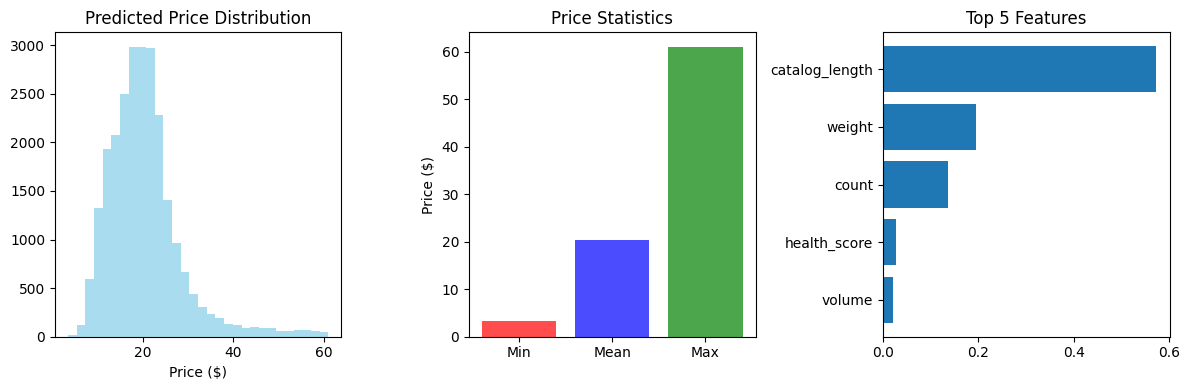

In [5]:
# FAST PIPELINE EXECUTION

def run_lightning_pipeline(train_file='../data/train.csv', test_file='../data/test.csv', method='fast'):
    """
    Complete pipeline that runs in minutes, not hours
    """
    try:
        print(f"⚡ LIGHTNING FAST PIPELINE - {method.upper()} METHOD")
        print("=" * 50)
        
        # 1. Load data
        print("1. Loading data...")
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        print(f"   Training: {train_df.shape}, Test: {test_df.shape}")
        
        # 2. Choose model based on speed requirement
        if method == 'fast':
            predictor = FastPricePredictor()
            results = predictor.train_lightning_fast(train_df, validate=True)
        elif method == 'instant':
            predictor = LightningPricePredictor()
            results = predictor.train_instant(train_df)
        else:
            raise ValueError("Choose 'fast' or 'instant'")
        
        # 3. Make predictions
        print("3. Making predictions...")
        predictions = predictor.predict(test_df)
        
        # 4. Save results
        output_file = f'../Model/lightning_predictions_{method}.csv'
        predictions[['sample_id', 'predicted_price']].to_csv(output_file, index=False)
        
        print("4. Results summary:")
        print(f"   Predictions saved: {output_file}")
        print(f"   Products predicted: {len(predictions)}")
        print(f"   Price range: ${predictions['predicted_price'].min():.2f} - ${predictions['predicted_price'].max():.2f}")
        
        if 'smape' in results:
            print(f"   Validation SMAPE: {results['smape']:.2f}%")
        
        # Quick visualization
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.hist(predictions['predicted_price'], bins=30, alpha=0.7, color='skyblue')
        plt.title('Predicted Price Distribution')
        plt.xlabel('Price ($)')
        
        plt.subplot(1, 3, 2)
        price_stats = predictions['predicted_price'].describe()
        plt.bar(['Min', 'Mean', 'Max'], 
                [price_stats['min'], price_stats['mean'], price_stats['max']],
                color=['red', 'blue', 'green'], alpha=0.7)
        plt.title('Price Statistics')
        plt.ylabel('Price ($)')
        
        plt.subplot(1, 3, 3)
        if hasattr(predictor.model, 'feature_importances_'):
            features = predictor.feature_columns
            importances = predictor.model.feature_importances_
            sorted_idx = np.argsort(importances)[-5:]  # Top 5
            plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
            plt.title('Top 5 Features')
        
        plt.tight_layout()
        plt.show()
        
        return predictor, predictions, results
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None, None

# RUN THE FAST PIPELINE
print("🚀 Starting lightning-fast training...")
fast_predictor, fast_predictions, fast_results = run_lightning_pipeline('../data/train.csv', '../data/test.csv', method='fast')

# For even faster results, use:
# instant_predictor, instant_predictions, instant_results = run_lightning_pipeline('train.csv', 'test.csv', method='instant')